Load necessary libraries.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
figure = 0

## Exercise 1: Training a multi-linear classifier

In this assignment, we will use a neural network with one input layer (as many nodes as images pixels) and one output layer (as many nodes as possible image labels and *SoftMax* as activation function) with the loss function cross entropy (classification metric) with L2 regularization. It is a simple network where no hidden layer will be used. Then, the predicted class corresponds to the label with the highest predicted probability (since the sum of the output activations for a sample is 1 as consequence of using *SoftMax*).

### Exercise 1.1

Load the data dividing the pixels by 255.

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    
    return dict

def one_hot(labels, number_distinct_labels=10):
    labels_one_hot = np.zeros(shape=(number_distinct_labels,len(labels)))
    for i, label in enumerate(labels):
        labels_one_hot[label,i] = 1
    
    return labels_one_hot

def LoadBatch(file):
    data = unpickle(file)
    images = data[b'data'].T/255
    labels = data[b'labels']
    labels_one_hot = one_hot(labels) 
    
    return images, labels_one_hot, labels

In [3]:
images_1, labels_one_hot_1, labels_1 = LoadBatch('cifar-10-batches-py/data_batch_1')
images_2, labels_one_hot_2, labels_2 = LoadBatch('cifar-10-batches-py/data_batch_2')
images_3, labels_one_hot_3, labels_3 = LoadBatch('cifar-10-batches-py/data_batch_3')
images_4, labels_one_hot_4, labels_4 = LoadBatch('cifar-10-batches-py/data_batch_4')
images_5, labels_one_hot_5, labels_5 = LoadBatch('cifar-10-batches-py/data_batch_5')
images_test, labels_one_hot_test, labels_test = LoadBatch('cifar-10-batches-py/test_batch')
batches = unpickle('cifar-10-batches-py/batches.meta')
label_names = [label_name.decode('utf-8') for label_name in batches[b'label_names']]

Each batch contains N=10000 images (columns) of D=3072 pixels (rows) and C=10 possible labels (targets). Y is an one-hot representation matrix of the labels of the images.

$$\underset{[D \times N]}{X} \qquad \underset{[C \times N]}{Y}$$

In [4]:
images_1.shape

(3072, 10000)

In [5]:
labels_one_hot_1.shape

(10, 10000)

The images have been normalized (pixel values between 0 and 1).

In [6]:
type(images_1[0,0]) # float equivalent to double

numpy.float64

In [7]:
images_1.min(), images_1.max()

(0.0, 1.0)

This is the distribution of labels by images batch.

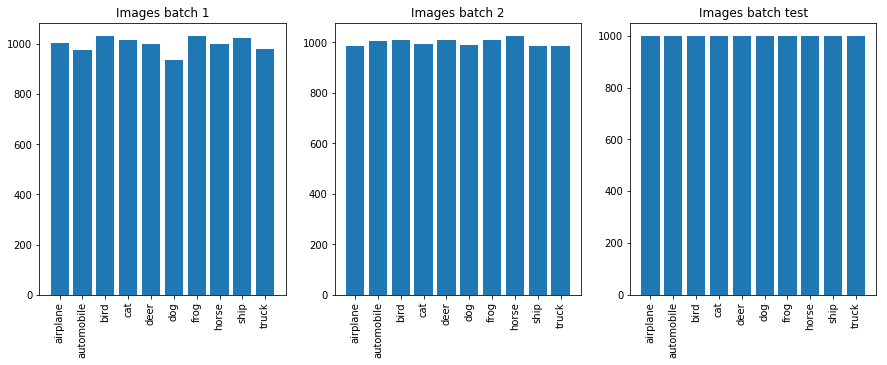

In [8]:
labels_list = [labels_1, labels_2, labels_test]
titles_list = ['Images batch '+str(i) for i in [1, 2, 'test']]
_, axes = plt.subplots(nrows=1, ncols=len(titles_list), figsize=(15,5))
for i, (labels, title) in enumerate(zip(labels_list, titles_list)):
    unique_labels = np.unique(labels)
    axes[i].bar(unique_labels, [labels.count(x) for x in unique_labels])
    axes[i].set_xticks(unique_labels)
    axes[i].set_xticklabels(labels=label_names, rotation=90)
    axes[i].set_title(title)
plt.savefig('Figures/'+str(figure)+'_Dist_Labels.png', bbox_inches="tight"); figure+=1

These are the first 5 images by label for the batch test.

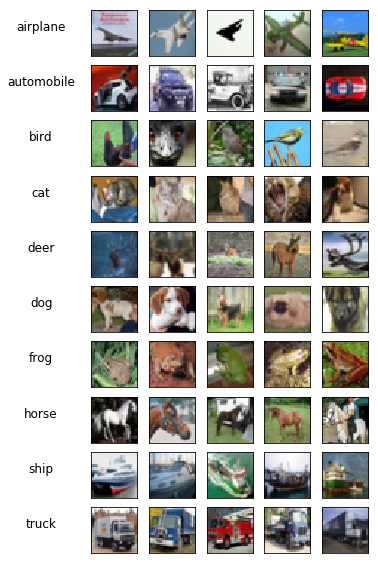

In [9]:
_, axes = plt.subplots(nrows=10, ncols=5, figsize=(5,10))
for label_index, label_name in enumerate(label_names):
    images = images_test[:,np.equal(labels_test, label_index)][:,0:5]
    for image_index, image in enumerate(images.T):
        axes[label_index][image_index].imshow(image.reshape(3,32,32).transpose([1,2,0]))
        axes[label_index][image_index].tick_params(bottom=False, top=False, left=False, right=False, 
                                                   labelbottom=False, labelleft=False)
    axes[label_index][0].set_ylabel(label_name, labelpad=50, rotation=0, size='large')
plt.savefig('Figures/'+str(figure)+'_Images.png', bbox_inches="tight"); figure+=1

### Exercise 1.2

Initialize the weights and bias matrix.

In [10]:
def initialize_weights(input_dimension, output_dimension, xavier=False, seed=0, std=0.01):
    # Define standard deviation for random weights and bias normal distribution
    scale = 1/np.sqrt(input_dimension) if xavier else std
    
    # Define random seed and initialize weights
    np.random.seed(seed)
    W = np.random.normal(size=(output_dimension, input_dimension), loc=0, scale=scale)
    
    # Define random seed and initialize bias
    np.random.seed(seed)
    b = np.random.normal(size=(output_dimension,1), loc=0, scale=scale)
    
    return W, b

In [11]:
input_dimension = images_1.shape[0]
output_dimension = labels_one_hot_1.shape[0]
W, b = initialize_weights(input_dimension, output_dimension)

The shape of the weights matrix is as many rows as output nodes and as many columns as input nodes. And for the bias only 1 column with as many rows as output nodes.

In [12]:
W.shape, b.shape

((10, 3072), (10, 1))

### Exercise 1.3

Create a function to evaluate images with given weights and bias.

$$\underset{[C \times N]}{S} = \underset{[C \times D]}{W} \times \underset{[D \times N]}{X} + \underset{[C \times 1]}{b}$$

$$\underset{[C \times N]}{P}=SoftMax\bigg(\underset{[C \times N]}{S}\bigg) \quad where \quad SoftMax(S_{ji})=\frac{exp(S_{ji})}{\sum_{c=1}^C exp(S_{ci})}$$

In [13]:
def softmax(S):
    exponential_S = np.exp(S)
    P = exponential_S/exponential_S.sum(axis=0)
    
    return P
    
def EvaluateClassifier(X, W, b):
    S = W@X+b
    P = softmax(S)
    
    return P

Predicting the label of the first 100 images of batch 1, the predictions matrix shape is as many rows as possible labels and as many columns as images evaluated.

In [14]:
EvaluateClassifier(images_1[:,0:100], W, b).shape

(10, 100)

### Exercise 1.4

Define the cost function for cross entropy loss with L2 regularization term on the weight matrix.

$$J=L+\lambda||W||^2=\frac{1}{N}\sum_{i=1}^{N} -log\bigg(\underset{[1 \times C]}{Y_{:i}^T} \times \underset{[C \times 1]}{P_{:i}}\bigg) +\lambda\sum_{c,d}^{C,D}W_{cd}^2 $$

In [15]:
def ComputeCost(X, Y, W, b, lambda_):
    # Compute the predictions
    P = EvaluateClassifier(X, W, b)
    
    # Compute the loss function term
    loss_cross = sum(-np.log((Y*P).sum(axis=0)))
    
    # Compute the regularization term
    loss_regularization = lambda_*(W**2).sum()
    
    # Sum the total cost
    J = loss_cross/X.shape[1]+loss_regularization
    
    return J

### Exercise 1.5

Define the accuracy function given somes images with the respective labels, and some weights and bias.

In [16]:
def ComputeAccuracy(X, y, W, b):
    # Compute the predictions
    P = EvaluateClassifier(X, W, b)
    
    # Compute the accuracy
    acc = np.mean(y==np.argmax(P, 0))
    
    return acc

Define the function to plot the confusion matrix given somes images with the respective labels, and some weights and bias.

In [17]:
def confusion_matrix(X, y, W, b=None, title=''):
    # Compute the predictions and the accuracy
    if b is None:
        P = EvaluateClassifierSVM(X, W)
        acc = np.round(ComputeAccuracySVM(X, y, W), 4)
    else:
        P = EvaluateClassifier(X, W, b)
        acc = np.round(ComputeAccuracy(X, y, W, b), 4)
    
    # Create the confusion matrix
    prediction = np.argmax(P, 0)
    K = len(np.unique(y))
    N = len(y)
    cross = np.zeros(shape=(K,K))
    for i in range(K):
        for j in range(K):
            cross[i,j] = np.sum([True if y[x]==i and prediction[x]==j else False for x in range(N)])
    cross = pd.DataFrame(data=cross.astype(int), columns=label_names, index=label_names)
    
    # Plot the confusion matrix
    plt.figure()
    sns.heatmap(cross, cbar=False, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Prediction")
    plt.ylabel("True label")
    plt.title("Accuracy="+str('%.2f' % (acc*100))+str("% ")+title)

### Exercise 1.6

Define the function to compute the gradients given some images and labels, the weights and the regularization parameter. We have used the following equations by data batches (and then update the weights and bias with vanilla updates equal to $-\eta$ times the following gradients).

$$\frac{\partial \lambda||W||^2}{\partial W} = 2\lambda\underset{[C \times D]}{W} \quad and \quad \frac{\partial L}{\partial W} = \frac{1}{N} \bigg(\underset{[C \times N]}{P} - \underset{[C \times N]}{Y}\bigg) \times \underset{[N \times D]}{X^T}$$

$$then \quad \frac{\partial J}{\partial W} = \frac{\partial L}{\partial W} + \frac{\partial \lambda||W||^2}{\partial W} \quad and \quad \frac{\partial J}{\partial b} = \frac{\partial L}{\partial b} = \frac{1}{N} \bigg(\underset{[C \times N]}{P} - \underset{[C \times N]}{Y}\bigg) \times \underset{[N \times 1]}{1}$$

In [18]:
def ComputeGradients(X, Y, P, W, lambda_):
    n = X.shape[1]
    C = Y.shape[0]
    G = -(Y-P)
    grad_W = (G@X.T)/n+2*lambda_*W
    grad_b = (G@np.ones(shape=(n,1))/n).reshape(C,1)
    
    return grad_W, grad_b

#### Reformulating ComputeGradsNum.m in Python (numerically computed gradient with finite difference method)

In [19]:
def ComputeGradsNum(X, Y, W, b, lambda_, h=0.000001):
    grad_W = np.zeros(shape=W.shape)
    grad_b = np.zeros(shape=b.shape)
    c = ComputeCost(X, Y, W, b, lambda_)
    
    for i in range(b.shape[0]):
        b_try = b.copy()
        b_try[i,0] = b_try[i,0]+h
        c2 = ComputeCost(X, Y, W, b_try, lambda_)
        grad_b[i,0] = (c2-c)/h
    
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = W.copy()
            W_try[i,j] = W_try[i,j]+h
            c2 = ComputeCost(X, Y, W_try, b, lambda_)
            grad_W[i,j] = (c2-c)/h
    
    return grad_W, grad_b

#### Compare the numerically and analytically computed gradient

We want to check that the gradients computed in the gradients function correspond to the correct gradients. To do this,
we compare the gradient obtained by the network with the gradient computed with the finite difference method.

- 20 first dimensions of the first image of data batch 1 without regularization:

In [20]:
X = images_1[0:20,[0]]
Y = labels_one_hot_1[:,[0]]
lambda_ = 0

# Compute the gradients analytically
P = EvaluateClassifier(X, W[:,0:20], b)
grad_W_analytical, grad_b_analytical = ComputeGradients(X, Y, P, W[:,0:20], lambda_)

# Compute the gradients numerically
grad_W_numerical, grad_b_numerical = ComputeGradsNum(X, Y, W[:,0:20], b, lambda_)

# Absolute error between numerically and analytically computed gradient
grad_W_abs_diff = np.abs(grad_W_numerical-grad_W_analytical)
grad_b_abs_diff = np.abs(grad_b_numerical-grad_b_analytical)
print('For weights: '+str(np.mean(grad_W_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias: '+str(np.mean(grad_b_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For weights the maximum absolute error is '+str((grad_W_abs_diff).max()))
print('For bias the maximum absolute error is '+str((grad_b_abs_diff).max()), "\n")

# Relative error between numerically and analytically computed gradient
grad_W_abs_sum = np.maximum(np.abs(grad_W_numerical)+np.abs(grad_W_analytical), 0.00000001)
grad_b_abs_sum = np.maximum(np.abs(grad_b_numerical)+np.abs(grad_b_analytical), 0.00000001)
print('For weights: '+str(np.mean(grad_W_abs_diff/grad_W_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For bias: '+str(np.mean(grad_b_abs_diff/grad_b_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For weights the maximum relative error is '+str((grad_W_abs_diff/grad_W_abs_sum).max()))
print('For bias the maximum relative error is '+str((grad_b_abs_diff/grad_b_abs_sum).max()))

For weights: 100.0% of absolute errors below 1e-6
For bias: 100.0% of absolute errors below 1e-6
For weights the maximum absolute error is 1.5539594055979933e-08
For bias the maximum absolute error is 4.6837922137998866e-08 

For weights: 100.0% of relative errors below 1e-6
For bias: 100.0% of relative errors below 1e-6
For weights the maximum relative error is 1.3081530098102853e-07
For bias the maximum relative error is 2.244309984168439e-07


- All dimensions of the first 5 images of batch 1 with regularization:

In [21]:
X = images_1[:,0:5]
Y = labels_one_hot_1[:,0:5]
lambda_ = 0.01

# Compute the gradients analytically
P = EvaluateClassifier(X, W, b)
grad_W_analytical, grad_b_analytical = ComputeGradients(X, Y, P, W, lambda_)

# Compute the gradients numerically
grad_W_numerical, grad_b_numerical = ComputeGradsNum(X, Y, W, b, lambda_)

# Absolute error between numerically and analytically computed gradient.
grad_W_abs_diff = np.abs(grad_W_numerical-grad_W_analytical)
grad_b_abs_diff = np.abs(grad_b_numerical-grad_b_analytical)
print('For weights: '+str(np.mean(grad_W_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For bias: '+str(np.mean(grad_b_abs_diff<1e-6)*100)+"% of absolute errors below 1e-6")
print('For weights the maximum absolute error is '+str((grad_W_abs_diff).max()))
print('For bias the maximum absolute error is '+str((grad_b_abs_diff).max()), "\n")

# Relative error between numerically and analytically computed gradient.
grad_W_abs_sum = np.maximum(np.abs(grad_W_numerical)+np.abs(grad_W_analytical), 0.00000001)
grad_b_abs_sum = np.maximum(np.abs(grad_b_numerical)+np.abs(grad_b_analytical), 0.00000001)
print('For weights: '+str(np.mean(grad_W_abs_diff/grad_W_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For bias: '+str(np.mean(grad_b_abs_diff/grad_b_abs_sum<1e-6)*100)+
      "% of relative errors below 1e-6")
print('For weights the maximum relative error is '+str((grad_W_abs_diff/grad_W_abs_sum).max()))
print('For bias the maximum relative error is '+str((grad_b_abs_diff/grad_b_abs_sum).max()))

For weights: 100.0% of absolute errors below 1e-6
For bias: 100.0% of absolute errors below 1e-6
For weights the maximum absolute error is 4.796284371055837e-08
For bias the maximum absolute error is 5.825246424118191e-08 

For weights: 92.82552083333333% of relative errors below 1e-6
For bias: 100.0% of relative errors below 1e-6
For weights the maximum relative error is 0.009698663566883117
For bias the maximum relative error is 4.430273631729571e-07


### Exercise 1.7

Define the function for the vanilla (fixed $\eta$) mini batch gradient descent.

$$W^{t+1} = W^{t} - \eta \frac{\partial J\big(Batch^{t+1}\big)}{\partial W} \quad where \quad \frac{\partial J\big(Batch^{t+1}\big)}{\partial W}= \frac{1}{N_{Batch^{t+1}}} \sum^{N_{Batch^{t+1}}}_{i=1}\frac{\partial J_i}{\partial W}$$

$$b^{t+1} = b^{t} - \eta \frac{\partial J\big(Batch^{t+1}\big)}{\partial b} \quad where \quad \frac{\partial J\big(Batch^{t+1}\big)}{\partial b}= \frac{1}{N_{Batch^{t+1}}} \sum^{N_{Batch^{t+1}}}_{i=1}\frac{\partial J_i}{\partial b}$$

In [22]:
def MiniBatchGD(X, Y, y, GDparams, W, b=None, lambda_=0, X_val=None, Y_val=None, y_val=None, 
                permutation=False, decay_eta=None, cost="Cross_Entropy", delta=1):
    n = X.shape[1]
    eta = GDparams['eta']
    n_batch = GDparams['n_batch']
    n_epochs = GDparams['n_epochs']
    
    # Create a copy of weights and bias to update
    W = W.copy()
    if b is not None:
        b = b.copy()
    
    # Create a dictionary to store the performance metrics
    metrics = {'epochs':[], 'loss_train':[], 'acc_train':[]}
    if X_val is not None:
        metrics['loss_val'] = []
        metrics['acc_val'] = []
    
    # Save original data if permutation at each epoch is required
    if permutation:
        X_original = X.copy()
        Y_original = Y.copy()
        y_original = y.copy()
    
    # Iterate epochs
    for epoch in range(n_epochs):        
        
        # Permute data if required
        if permutation:
            np.random.seed(epoch)
            permuted_indexes = np.random.permutation(n)
            X = X_original[:,permuted_indexes]
            Y = Y_original[:,permuted_indexes]
            y = [y_original[index] for index in permuted_indexes]
        
        # Iterate data batches or splits
        for j in range(n//n_batch):
            j_start = j*n_batch
            j_end = (j+1)*n_batch
            inds = range(j_start, j_end)
            X_batch = X[:,inds]
            Y_batch = Y[:,inds]
            y_batch = [y[index] for index in inds]
            
            # Compute gradients and update weights and bias for this batch
            if cost=="Cross_Entropy":
                P_batch = EvaluateClassifier(X_batch, W, b)
                grad_W, grad_b = ComputeGradients(X_batch, Y_batch, P_batch, W, lambda_)
                W += -eta*grad_W
                b += -eta*grad_b
            elif cost=="SVM":
                grad_W = ComputeGradientsSVM(X_batch, Y_batch, y_batch, W, lambda_, delta)                
                W += -eta*grad_W
        
        # Save the performance metrics of the epoch
        metrics['epochs'].append(epoch+1)
        if cost=="Cross_Entropy":
            metrics['acc_train'].append(ComputeAccuracy(X, y, W, b))
            metrics['loss_train'].append(ComputeCost(X, Y, W, b, lambda_))
        elif cost=="SVM":
            metrics['acc_train'].append(ComputeAccuracySVM(X, y, W))
            metrics['loss_train'].append(ComputeCostSVM(X, Y, W, lambda_))
        if X_val is not None:
            if cost=="Cross_Entropy":
                metrics['acc_val'].append(ComputeAccuracy(X_val, y_val, W, b))
                metrics['loss_val'].append(ComputeCost(X_val, Y_val, W, b, lambda_))
            elif cost=="SVM":
                metrics['acc_val'].append(ComputeAccuracySVM(X_val, y_val, W))
                metrics['loss_val'].append(ComputeCostSVM(X_val, Y_val, W, lambda_))  
        
        # Show monitoring message of training
        sys.stdout.write("In epoch "+str(epoch+1)+": loss="+str(metrics['loss_train'][-1])+
                         " and accuracy="+str(metrics['acc_train'][-1])+"\r")
        
        # Decay the learning rate if required
        if decay_eta is not None:
            eta *= decay_eta
    
    if b is not None:
        return W, b, metrics
    else:
        return W, metrics

#### Visualization of the learning curve

In [23]:
def plot_learning_curve(metrics, title=''):
    _, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.suptitle('Learning curves '+title)
    
    # Iterate the performance metrics
    for metric, ax in zip(['loss','acc'], axes.flatten()):
        
        # Find the optimal metric value and the corresponding epoch for training set
        optimal_epoch_train = np.argmin(metrics[metric+'_train']) if metric=='loss' else \
                              np.argmax(metrics[metric+'_train'])
        optimal_train = np.round(metrics[metric+'_train'][optimal_epoch_train], 4)
        
        # Plot the learning curve of training set
        label = 'Train: '+str(optimal_train)+' at epoch '+str(optimal_epoch_train+1)
        ax.plot(metrics['epochs'], metrics[metric+'_train'], label=label)
        
        # If validation set...
        if len(metrics)>3:
            
            # Find the optimal metric value and the corresponding epoch for training set
            optimal_epoch_val = np.argmin(metrics[metric+'_val']) if metric=='loss' else \
                                np.argmax(metrics[metric+'_val'])
            optimal_val = np.round(metrics[metric+'_val'][optimal_epoch_val], 4)
            
            # Plot the learning curve of validation set
            label = 'Validation: '+str(optimal_val)+' at epoch '+str(optimal_epoch_val+1)
            ax.plot(metrics['epochs'], metrics[metric+'_val'], label=label)
        
        # Add axis, legend and grid
        ax.set_xlabel("Epochs")
        ax.set_ylabel('Accuracy' if metric=='acc' else 'Loss')
        ax.legend()
        ax.grid(True)

#### Visualization of the weight matrix W

In [24]:
def plot_weights_by_output_node(W, label_names, title=''):
    _, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,2.5))
    plt.suptitle('Visualization of weights'+title)
    
    # Iterate the 10 created subplots (1 for each output node)
    for c, ax in enumerate(axes.flatten()):
        
        # Subset the corresponding output node weights
        image = W[c,:]
        
        # Show the weights in image format
        min_image = min(image)
        max_image = max(image)
        image = (image-min_image)/(max_image-min_image)
        ax.imshow(image.reshape(3,32,32).transpose([1,2,0]))
        ax.axis('off')
        ax.set_title(label_names[c])

### Training with given parametrizations

Using data in the file *data_batch_1* for training and the file *data_batch_2* for validation.

- Case 1: lambda=0, n_epochs=40, n_batch=100, eta=.1

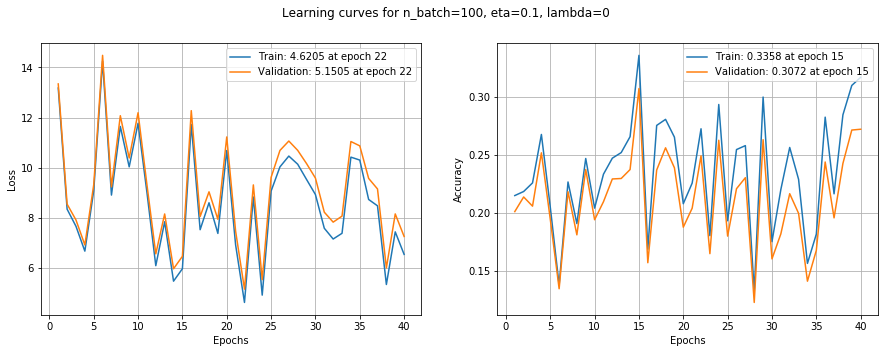

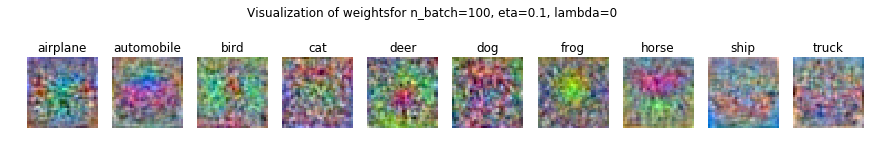

In [25]:
# Define the network parameters
lambda_1 = 0
GDparams_1 = {'n_batch':100, 'eta':0.1, 'n_epochs':40}

# Train the network
Wstar_1, bstar_1, metrics_1 = MiniBatchGD(images_1, labels_one_hot_1, labels_1, GDparams_1, W, b,
                                          lambda_1, X_val=images_2, Y_val=labels_one_hot_2, 
                                          y_val=labels_2)

# Plot the learning curve
title_1 = 'for n_batch=100, eta=0.1, lambda=0'
plot_learning_curve(metrics_1, title=title_1)
plt.savefig('Figures/'+str(figure)+'_Curves_C1.png', bbox_inches="tight"); figure+=1

# Plot the weights
plot_weights_by_output_node(Wstar_1, label_names, title=title_1)
plt.savefig('Figures/'+str(figure)+'_Weights_C1.png', bbox_inches="tight"); figure+=1

- Case 2: lambda=0, n_epochs=40, n_batch=100, eta=.01

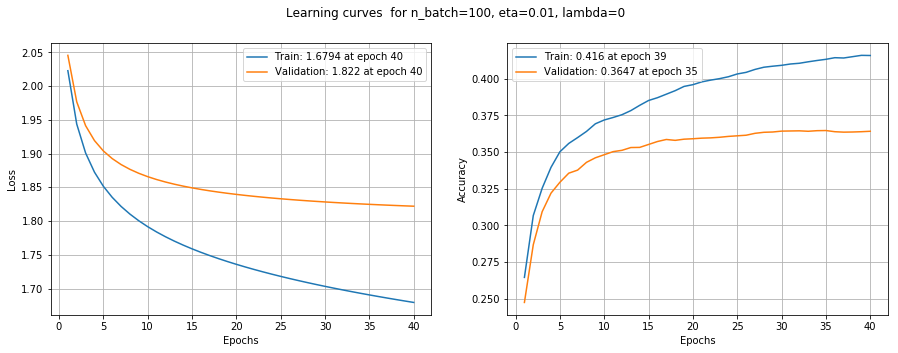

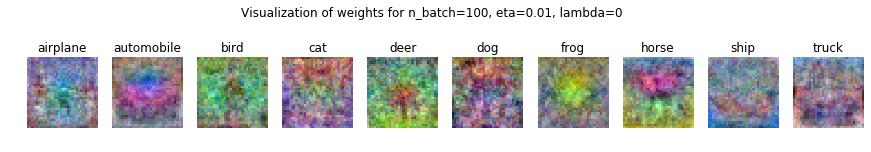

In [26]:
# Define the network parameters
lambda_2 = 0
GDparams_2 = {'n_batch':100, 'eta':0.01, 'n_epochs':40}

# Train the network
Wstar_2, bstar_2, metrics_2 = MiniBatchGD(images_1, labels_one_hot_1, labels_1, GDparams_2, W, b,
                                          lambda_2, X_val=images_2, Y_val=labels_one_hot_2,
                                          y_val=labels_2)

# Plot the learning curve
title_2 = ' for n_batch=100, eta=0.01, lambda=0'
plot_learning_curve(metrics_2, title=title_2)
plt.savefig('Figures/'+str(figure)+'_Curves_C2.png', bbox_inches="tight"); figure+=1

# Plot the weights
plot_weights_by_output_node(Wstar_2, label_names, title=title_2)
plt.savefig('Figures/'+str(figure)+'_Weights_C2.png' ,bbox_inches="tight"); figure+=1

- Case 3: lambda=.1, n_epochs=40, n_batch=100, eta=.01

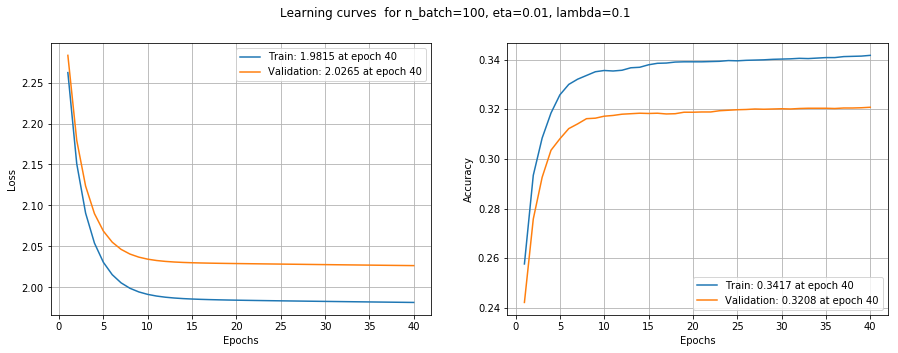

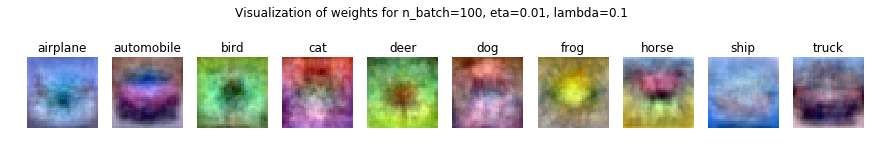

In [27]:
# Define the network parameters
lambda_3 = 0.1
GDparams_3 = {'n_batch':100, 'eta':0.01, 'n_epochs':40}

# Train the network
Wstar_3, bstar_3, metrics_3 = MiniBatchGD(images_1, labels_one_hot_1, labels_1, GDparams_3, W, b,
                                          lambda_3, X_val=images_2, Y_val=labels_one_hot_2,
                                          y_val=labels_2)

# Plot the learning curve
title_3 = ' for n_batch=100, eta=0.01, lambda=0.1'
plot_learning_curve(metrics_3, title=title_3)
plt.savefig('Figures/'+str(figure)+'_Curves_C3.png', bbox_inches="tight"); figure+=1

# Plot the weights
plot_weights_by_output_node(Wstar_3, label_names, title=title_3)
plt.savefig('Figures/'+str(figure)+'_Weights_C3.png', bbox_inches="tight"); figure+=1

- Case 4: lambda=1, n_epochs=40, n_batch=100, eta=.01

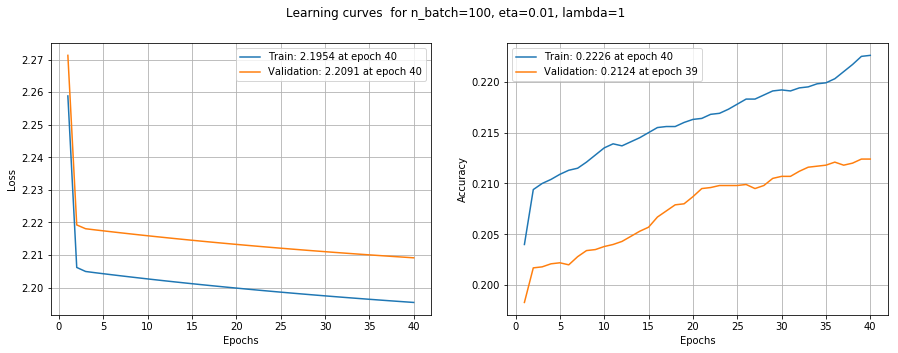

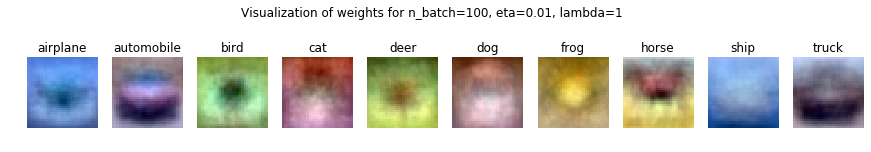

In [28]:
# Define the network parameters
lambda_4 = 1
GDparams_4 = {'n_batch':100, 'eta':0.01, 'n_epochs':40}

# Train the network
Wstar_4, bstar_4, metrics_4 = MiniBatchGD(images_1, labels_one_hot_1, labels_1, GDparams_4, W, b,
                                          lambda_4, X_val=images_2, Y_val=labels_one_hot_2,
                                          y_val=labels_2)

# Plot the learning curve
title_4 = ' for n_batch=100, eta=0.01, lambda=1'
plot_learning_curve(metrics_4, title=title_4)
plt.savefig('Figures/'+str(figure)+'_Curves_C4.png', bbox_inches="tight"); figure+=1

# Plot the weights
plot_weights_by_output_node(Wstar_4, label_names, title=title_4)
plt.savefig('Figures/'+str(figure)+'_Weights_C4.png', bbox_inches="tight"); figure+=1

#### Effect of increasing the amount of regularization: comparing weights with histogram

In [29]:
def histogram_list_of_weights(list_of_weights, label_of_weights, title='Histogram of weights'):
    plt.figure(figsize=(5,5))

    # Iterate the list of weights
    for W, label in zip(list_of_weights, label_of_weights):
        
        # Plot the histogram of the iteration weights
        plt.hist(W.flatten(), alpha=0.5, label=label, log=False)
    
    # Add axis, legend and title
    plt.xlabel("Weight")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(title)

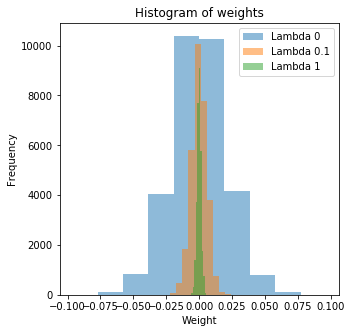

In [30]:
# Define the list of weights to plot
list_of_weights = [Wstar_2, Wstar_3, Wstar_4]
label_of_weights = ["Lambda 0", "Lambda 0.1", "Lambda 1"]

# Plot the histograms
histogram_list_of_weights(list_of_weights, label_of_weights)
plt.savefig('Figures/'+str(figure)+'_Histrogram_W.png', bbox_inches="tight"); figure+=1

#### Test accuracy of networks

- Case 1: lambda=0, n_epochs=40, n_batch=100, eta=.1

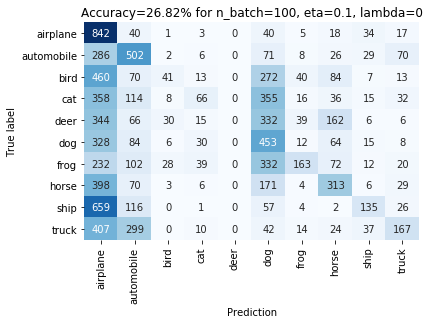

In [31]:
confusion_matrix(images_test, labels_test, Wstar_1, bstar_1, title_1)
plt.savefig('Figures/'+str(figure)+'_Confusion_C1.png', bbox_inches="tight"); figure+=1

- Case 2: lambda=0, n_epochs=40, n_batch=100, eta=.01

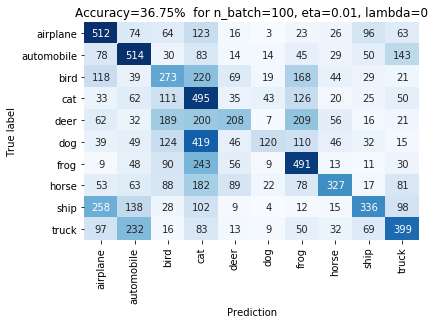

In [32]:
confusion_matrix(images_test, labels_test, Wstar_2, bstar_2, title_2)
plt.savefig('Figures/'+str(figure)+'_Confusion_C2.png', bbox_inches="tight"); figure+=1

- Case 3: lambda=.1, n_epochs=40, n_batch=100, eta=.01

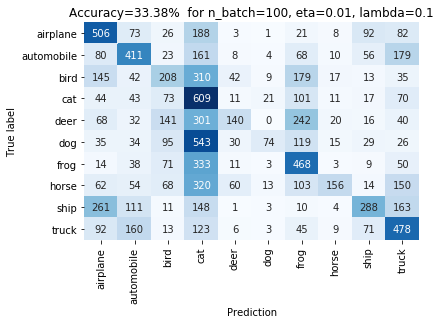

In [33]:
confusion_matrix(images_test, labels_test, Wstar_3, bstar_3, title_3)
plt.savefig('Figures/'+str(figure)+'_Confusion_C3.png', bbox_inches="tight"); figure+=1

- Case 4: lambda=1, n_epochs=40, n_batch=100, eta=.01

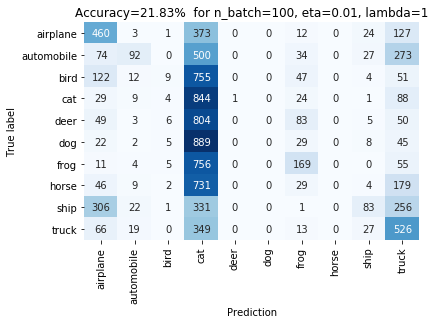

In [34]:
confusion_matrix(images_test, labels_test, Wstar_4, bstar_4, title_4)
plt.savefig('Figures/'+str(figure)+'_Confusion_C4.png', bbox_inches="tight"); figure+=1

## Exercise 2 (Bonus points)

## 2.1 Optimize the performance of the network

We will compare the results of next tricks or modifications with the parametrization with best loss in validation set, case 2.

In [35]:
# Define the network parameters
lambda_2 = 0
GDparams_2 = {'n_batch':100, 'eta':0.01, 'n_epochs':40}
title_2 = ' for n_batch=100, eta=0.01, lambda=0'

### Exercise 2.1.a

Use all the available training data for training (all five batches minus a small subset of the training images for a validation set). Decrease the size of the validation set down ~ 1000.

In [36]:
# Stack all the data batches
images = np.hstack((images_1, images_2, images_3, images_4, images_5))
labels_one_hot = np.hstack((labels_one_hot_1, labels_one_hot_2, labels_one_hot_3, labels_one_hot_4,
                            labels_one_hot_5))
labels = labels_1+labels_2+labels_3+labels_4+labels_5

# Subset the validation set
np.random.seed(0)
indexes_validation = np.random.choice(range(images.shape[1]), 1000, replace=False)
images_val = images[:,indexes_validation]
images_train = np.delete(images, indexes_validation, 1)
labels_one_hot_val = labels_one_hot[:,indexes_validation]

# Subset the training set
labels_one_hot_train = np.delete(labels_one_hot, indexes_validation, 1)
labels_val = [labels[i] for i in indexes_validation]
labels_train = [labels[i] for i in range(images.shape[1]) if i not in indexes_validation]

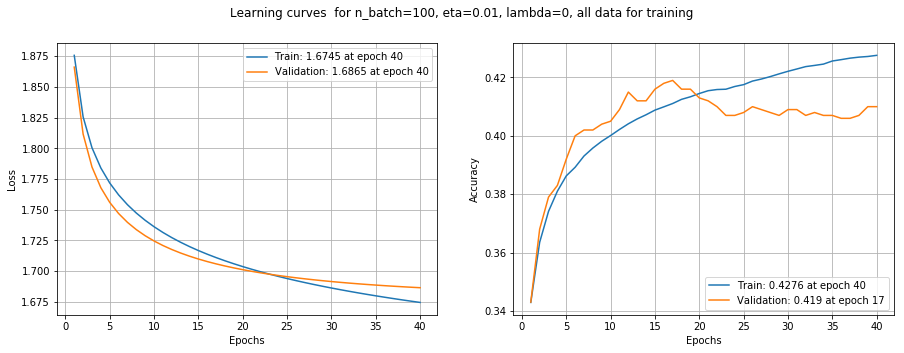

In [37]:
# Train the network
Wstar_2_all, bstar_2_all, metrics_2_all = MiniBatchGD(images_train, labels_one_hot_train, labels_train, 
                                                      GDparams_2, W, b, lambda_2, X_val=images_val, 
                                                      Y_val=labels_one_hot_val, y_val=labels_val)

# Plot the learning curves
plot_learning_curve(metrics_2_all, title=title_2+str(', all data for training'))
plt.savefig('Figures/'+str(figure)+'_Curves_C2_All.png', bbox_inches="tight"); figure+=1

### Exercise 2.1.b

Train for a longer time and use your validation set to make sure you don't overfit or to keep a record of the best model before you begin to overfit.

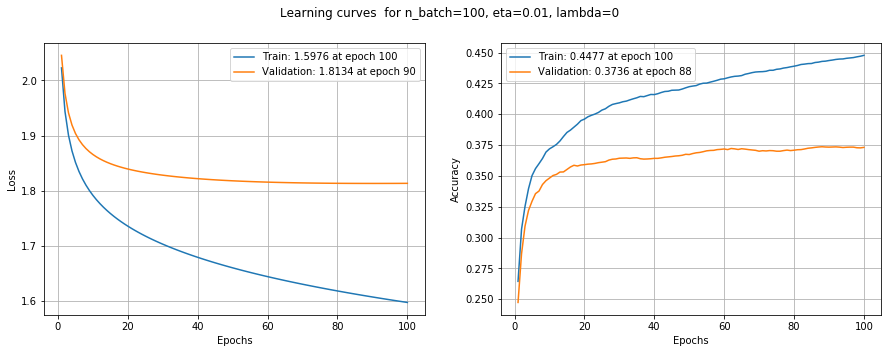

In [38]:
# Define the network parameters
GDparams_2_long = {'n_batch':100, 'eta':0.01, 'n_epochs':100}

# Train the network
Wstar_2_long, bstar_2_long, metrics_2_long = MiniBatchGD(images_1, labels_one_hot_1, labels_1, 
                                                         GDparams_2_long, W, b, lambda_2, X_val=images_2,
                                                         Y_val=labels_one_hot_2, y_val=labels_2)

# Plot the learning curves
plot_learning_curve(metrics_2_long, title=title_2)
plt.savefig('Figures/'+str(figure)+'_Curves_C2_Long.png', bbox_inches="tight"); figure+=1

### Exercise 2.1.c

Do a grid search to find good values for the amount of regularization, the learning rate and the batch size. There is some significant empirical evidence that training with smaller batch sizes when using SGD training leads to better generalization.

In [39]:
# Define the list of parameters to search
lambdas = [0, 0.0001, 0.01]
etas = [0.0001, 0.01, 0.1]
n_batchs = [10, 100, 200]

# Iterate all parameters combinations
grid_search = pd.DataFrame({'lambda':[], 'eta':[], 'n_batch':[], 'loss_train':[], 'loss_val':[]})
for i, (lambda_, eta, n_batch) in enumerate(list(itertools.product(*[lambdas, etas, n_batchs]))):
    
    # Define the network parameters
    GDparams = {'n_batch':n_batch, 'eta':eta, 'n_epochs':40}
    
    # Train the network
    Wstar, bstar, metrics = MiniBatchGD(images_1, labels_one_hot_1, labels_1, GDparams, W, b, lambda_, 
                                        X_val=images_2, Y_val=labels_one_hot_2, y_val=labels_2)
    
    # Append performance metrics
    grid_search = grid_search.append({'eta':eta, 'lambda':lambda_, 'n_batch':n_batch,
                                      'loss_train':metrics['loss_train'][-1],
                                      'loss_val':metrics['loss_val'][-1]}, ignore_index=True)

In [40]:
grid_search.sort_values(['loss_val'], inplace=True)
figure += 1
grid_search

,lambda,eta,n_batch,loss_train,loss_val
5,0.0000,0.0100,200.0,1.718204,1.821261
4,0.0000,0.0100,100.0,1.679381,1.821987
14,0.0001,0.0100,200.0,1.719216,1.822126
13,0.0001,0.0100,100.0,1.681038,1.823257
23,0.0100,0.0100,200.0,1.791565,1.881746
0,0.0000,0.0001,10.0,1.845626,1.893115
9,0.0001,0.0001,10.0,1.846098,1.893573
22,0.0100,0.0100,100.0,1.782893,1.894891
18,0.0100,0.0001,10.0,1.887810,1.933911
3,0.0000,0.0100,10.0,1.657690,2.068721


### Exercise 2.1.d

Play around with decaying the learning rate by a factor ~ 0.9 after each epoch. Or you can decay the learning rate by a factor of 10 after every nth epoch.

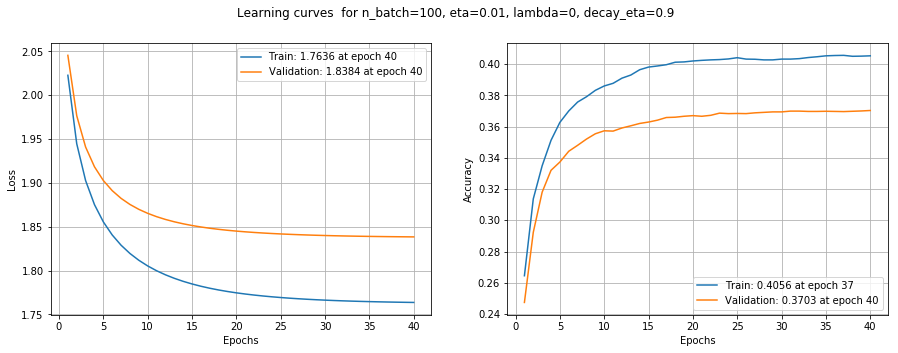

In [41]:
# Train the network
Wstar_2_decay, bstar_2_decay, metrics_2_decay = MiniBatchGD(images_1, labels_one_hot_1, labels_1, 
                                                            GDparams_2, W, b, lambda_2, X_val=images_2, 
                                                            Y_val=labels_one_hot_2, y_val=labels_2, 
                                                            decay_eta=0.9)

# Plot the learning curves
plot_learning_curve(metrics_2_decay, title=title_2+', decay_eta=0.9')
plt.savefig('Figures/'+str(figure)+'_Curves_C2_Decay.png', bbox_inches="tight"); figure+=1

### Exercise 2.1.e

Implement Xavier initialization and comment if it stabilizes training.

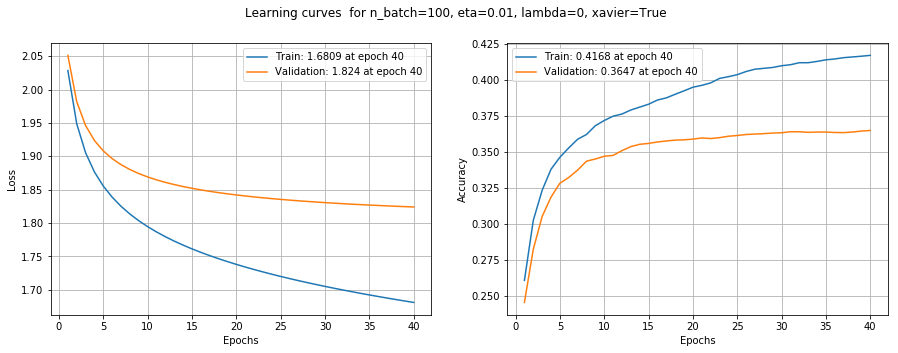

In [42]:
# Initialize the weights and bias with Xavier
W_xavier, b_xavier = initialize_weights(input_dimension, output_dimension, xavier=True)

# Train the network
Wstar_2_xavier, bstar_2_xavier, metrics_2_xavier = MiniBatchGD(images_1, labels_one_hot_1, labels_1, 
                                                               GDparams_2, W_xavier, b_xavier, lambda_2, 
                                                               X_val=images_2, Y_val=labels_one_hot_2, 
                                                               y_val=labels_2)

# Plot the learning curves
plot_learning_curve(metrics_2_xavier, title=title_2+', xavier=True')
plt.savefig('Figures/'+str(figure)+'_Curves_C2_Xavier.png', bbox_inches="tight"); figure+=1

### Exercise 2.1.g

Shuffle the order of your training examples at the beginning of every epoch.

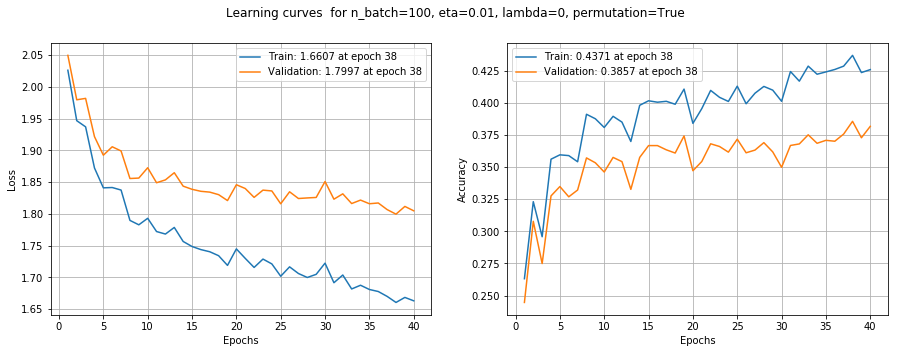

In [43]:
# Train the network
Wstar_2_perm, bstar_2_perm, metrics_2_perm = MiniBatchGD(images_1, labels_one_hot_1, labels_1, GDparams_2,
                                                         W, b, lambda_2, permutation=True, X_val=images_2,
                                                         Y_val=labels_one_hot_2, y_val=labels_2)

# Plot the learning curves
plot_learning_curve(metrics_2_perm, title=title_2+', permutation=True')
plt.savefig('Figures/'+str(figure)+'_Curves_C2_Permutation.png', bbox_inches="tight"); figure+=1

### Exercise 2.1.h

Train several networks using different initializations of the network's parameters. Then apply the ensemble to a test image and use the majority vote as the prediction.

In [44]:
def ensemble(iterations, X, Y, y, X_test, Y_test, y_test, GDparams, lambda_, permutation=False,
             decay_eta=None):
    n = X.shape[1]
    input_dimension = X.shape[0]
    output_dimension = Y.shape[0] 
    votes = np.zeros(shape=(iterations,n))

    # Iterate the ensemble rounds
    for i in range(iterations):
        
        # Initialize the weights
        W, b = initialize_weights(input_dimension, output_dimension, seed=i)
        
        # Train the network
        Wstar, bstar, metrics = MiniBatchGD(X, Y, y, GDparams, W, b, lambda_, permutation=permutation, 
                                            decay_eta=decay_eta)
        
        # Compute the predictions and the votes
        P_test = EvaluateClassifier(X_test, Wstar, bstar)
        votes[i,:] = np.argmax(P_test, 0)
    
    # Compute and return the majority vote
    majority_votes = stats.mode(votes).mode
    
    return majority_votes

In [45]:
majority_votes = ensemble(10, images_1, labels_one_hot_1, labels_1, images_2, labels_one_hot_2, labels_2,
                          GDparams_2, lambda_2, permutation=False, decay_eta=None)

In [46]:
print('With ensembling the accuracy in validation set is '+str(np.mean(labels_2==majority_votes)*100)+'%')

With ensembling the accuracy in validation set is 36.36%


### Trained network with the best test accuracy

In [47]:
print("With modification 'training with all data' the test accuracy is:")
print(str(ComputeAccuracy(images_test, labels_test, Wstar_2_all, bstar_2_all)*100)+'%\n')

print("With modification 'training for long' the test accuracy is:")
print(str(ComputeAccuracy(images_test, labels_test, Wstar_2_long, bstar_2_long)*100)+'%\n')

print("With modification 'training with learning rate decay' the test accuracy is:")
print(str(ComputeAccuracy(images_test, labels_test, Wstar_2_decay, bstar_2_decay)*100)+'%\n')

print("With modification 'training with Xavier initialization' the test accuracy is:")
print(str(ComputeAccuracy(images_test, labels_test, Wstar_2_xavier, bstar_2_xavier)*100)+"%\n")

print("With modification 'training with data permutation' the test accuracy is:")
print(str(ComputeAccuracy(images_test, labels_test, Wstar_2_perm, bstar_2_perm)*100)+"%\n")

majority_votes = ensemble(10, images_1, labels_one_hot_1, labels_1, images_test, labels_one_hot_test,
                          labels_test, GDparams_2, lambda_2)
print("\nWith modification 'ensembling' the test accuracy is:")
print(str(np.mean(labels_test==majority_votes)*100)+'%')

With modification 'training with all data' the test accuracy is:
40.160000000000004%

With modification 'training for long' the test accuracy is:
37.05%

With modification 'training with learning rate decay' the test accuracy is:
37.519999999999996%

With modification 'training with Xavier initialization' the test accuracy is:
36.620000000000005%

With modification 'training with data permutation' the test accuracy is:
38.14%

In epoch 40: loss=1.6795926053693402 and accuracy=0.4149
With modification 'ensembling' the test accuracy is:
36.9%


## 2.2 Train network by minimizing the SVM multi-class loss

Create a function to evaluate images with given weights.

In [48]:
def EvaluateClassifierSVM(X, W):
    S = W@X
    
    return S

Define the accuracy function given somes images with the respective labels, and some weights.

In [49]:
def ComputeAccuracySVM(X, y, W):
    # Compute the predictions
    S = EvaluateClassifierSVM(X, W)
    
    # Compute the accuracy
    acc = np.mean(y==np.argmax(S,0))
    
    return acc

Define the cost function for SVM loss.

$$J=L+\lambda |W| ^2=\frac{1}{N}\sum_{i=1}^{N} \sum_{\underset{j\neq y^i}{j=1}}^{C} max(0,s_{ji}-s_{y^{i}i}+\delta) +\lambda\sum_{c,d}^{C,D}W_{ij}^2$$

In [50]:
def ComputeCostSVM(X, Y, W, lambda_, delta=1):
    # Compute the predictions
    s = EvaluateClassifierSVM(X, W)
    
    # Compute the margins
    margins = np.maximum(0, (s-np.sum(s*Y, axis=0)+delta)*(1-Y))
    
    # Compute the loss function term
    n = X.shape[1]
    loss_svm = np.sum(margins)/n
    
    # Compute the regularization term
    loss_regularization = lambda_*(W**2).sum()
    
    # Sum the total cost
    J = loss_svm + loss_regularization
    
    return J

Define the function to compute the gradients given some images and labels, the weights and the regularization parameter.

In [51]:
def ComputeGradientsSVM(X, Y, y, W, lambda_, delta=1):
    n = X.shape[1]
    s = EvaluateClassifierSVM(X, W)
    margins = np.maximum(0, (s-np.sum(s*Y, axis=0)+delta)*(1-Y))
    dL_dS = margins
    dL_dS[margins>0] = 1
    dL_dS[y,np.arange(n)] = -np.sum(dL_dS, axis=0)
    grad_W = dL_dS@X.T/n
    grad_W += 2*lambda_*W
    
    return grad_W

Use the bias trick to initialize the weights with an extra column and add an extra row of 1 to the images.

In [52]:
W_SVM, _ = initialize_weights(input_dimension+1, output_dimension)
images_1_SVM = np.vstack((images_1, np.ones(shape=(1,images_1.shape[1]))))
images_2_SVM = np.vstack((images_2, np.ones(shape=(1,images_2.shape[1]))))
images_test_SVM = np.vstack((images_test, np.ones(shape=(1,images_test.shape[1]))))

#### Comparing test accuracy of SVM and cross entropy loss

Do a grid search to find good values for the amount of regularization, the learning rate and the batch size.

In [53]:
# Define the list of parameters
lambdas = [0, 0.0001, 0.01]
etas = [0.0001, 0.01, 0.1]
n_batchs = [10, 100, 200]

# Iterate all the parameters combinations
grid_search = pd.DataFrame({'lambda':[], 'eta':[], 'n_batch':[], 'Test Accuracy CE':[],
                            'Test Accuracy SVM':[]})
for i, (lambda_, eta, n_batch) in enumerate(list(itertools.product(*[lambdas,etas,n_batchs]))):
    
    # Define the network parameters
    GDparams = {'n_batch':n_batch, 'eta':eta, 'n_epochs':40}
    
    # Train the network with cross entropy loss function
    Wstar_CE, bstar_CE, metrics_CE = MiniBatchGD(images_1, labels_one_hot_1, labels_1, GDparams, W, b,
                                                 lambda_, X_val=images_test, Y_val=labels_one_hot_test,
                                                 y_val=labels_test)
    
    # Train the network with SVM loss function
    Wstar_SVM, metrics_SVM = MiniBatchGD(images_1_SVM, labels_one_hot_1, labels_1, GDparams, W_SVM, 
                                         b=None, lambda_=lambda_, X_val=images_test_SVM, 
                                         Y_val=labels_one_hot_test, y_val=labels_test, cost="SVM")
    
    # Append the performance metrics
    grid_search = grid_search.append({'eta':eta, 'lambda':lambda_, 'n_batch':n_batch,
                                      'Test Accuracy CE':metrics_CE['acc_val'][-1],
                                      'Test Accuracy SVM':metrics_SVM['acc_val'][-1]}, ignore_index=True)

In [54]:
grid_search.sort_values(['Test Accuracy SVM'], inplace=True, ascending=False)
figure += 1
grid_search

,lambda,eta,n_batch,Test Accuracy CE,Test Accuracy SVM
0,0.0000,0.0001,10.0,0.3576,0.3622
9,0.0001,0.0001,10.0,0.3576,0.3620
18,0.0100,0.0001,10.0,0.3566,0.3619
19,0.0100,0.0001,100.0,0.2782,0.3486
1,0.0000,0.0001,100.0,0.2776,0.3485
10,0.0001,0.0001,100.0,0.2777,0.3485
2,0.0000,0.0001,200.0,0.2318,0.3390
20,0.0100,0.0001,200.0,0.2317,0.3390
11,0.0001,0.0001,200.0,0.2318,0.3389
13,0.0001,0.0100,100.0,0.3674,0.3174


- Optimal case SVM: lambda=0.01, n_epochs=40, n_batch=10, eta=.0001

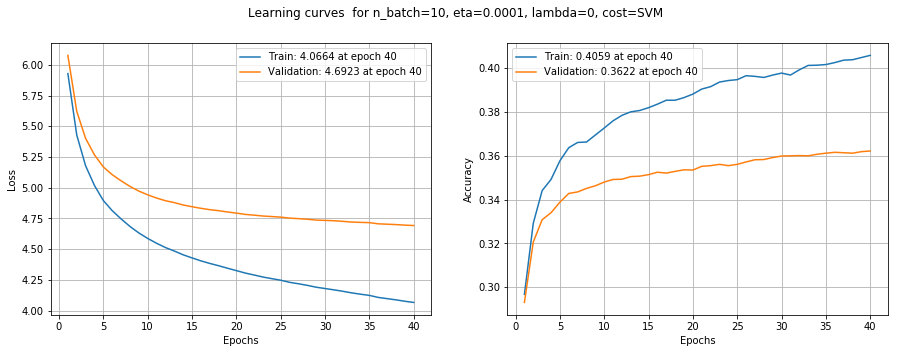

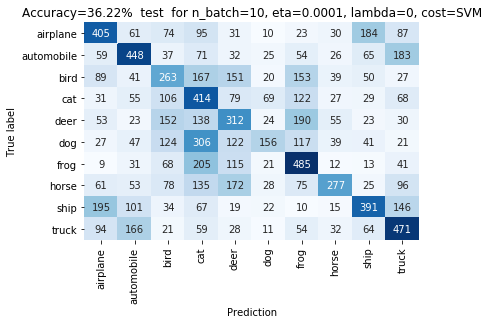

In [55]:
# Define the network parameters
lambda_SVM = 0
GDparams_SVM = {'n_batch':10, 'eta':0.0001, 'n_epochs':40}

# Train the network
Wstar_SVM, metrics_SVM = MiniBatchGD(images_1_SVM, labels_one_hot_1, labels_1, GDparams_SVM, W_SVM, 
                                     b=None, lambda_=lambda_SVM, X_val=images_test_SVM,
                                     Y_val=labels_one_hot_test, y_val=labels_test, cost="SVM")

# Plot the learnign curves
title_SVM = ' for n_batch=10, eta=0.0001, lambda=0, cost=SVM'
plot_learning_curve(metrics_SVM, title=title_SVM)
plt.savefig('Figures/'+str(figure)+'_Curves_SVM.png', bbox_inches="tight"); figure+=1

# Plot the confusion matrix
confusion_matrix(images_test_SVM, labels_test, Wstar_SVM, title=' test '+title_SVM)
plt.savefig('Figures/'+str(figure)+'_Confusion_SVM.png', bbox_inches="tight"); figure+=1